<a href="https://colab.research.google.com/github/jhubar/master-thesis/blob/main/LMV2_BASE_bbt_qv_date.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Install dependencies

In [1]:
!rm -r transformers
!git clone https://github.com/huggingface/transformers.git
!cd tranformers
!pip install -q ./transformers 

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 109640, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 109640 (delta 1), reused 2 (delta 0), pack-reused 109633
Receiving objects: 100% (109640/109640), 96.91 MiB | 30.61 MiB/s, done.
Resolving deltas: 100% (79945/79945), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
    

In [2]:
!pip install -q datasets seqeval

     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 136 kB 55.0 MB/s 
     |████████████████████████████████| 212 kB 55.3 MB/s 
     |████████████████████████████████| 1.1 MB 58.5 MB/s 
     |████████████████████████████████| 127 kB 62.3 MB/s 
     |████████████████████████████████| 144 kB 59.6 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 271 kB 63.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=a0b4594300ef9866129972b92af4f4b11cff391f6c3468ad59fe88e942e5f94a
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 13 kB/s 
     |████████████████████████████████| 17.3 MB 66.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Success

In [4]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.4 MB/s 


In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
path_btt_large_qv = '/content/drive/MyDrive/LayoutLMv2/final/btt_large_star_qv'

In [7]:
train = pd.read_pickle(path_btt_large_qv+'/pickel/train.pkl')
val = pd.read_pickle(path_btt_large_qv+'/pickel/dev.pkl')
test = pd.read_pickle(path_btt_large_qv+'/pickel/test.pkl')

## Prepare the data



In [8]:
from collections import Counter

all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'BASE_ID': 15108,
         'Base': 9452,
         'DueDate': 10898,
         'TAX_ID': 16673,
         'TOT_AMOUNT_ID': 17393,
         'TotAmount': 9196,
         'noise': 1605677,
         'tax': 9044})

Let's replace label noise by the "neutral" label "O" (which stands for "Outside").

In [9]:
replacing_labels = {'noise': 'O'}

In [10]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]


train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]


In [11]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)
labels = list(set(all_labels))
print(labels)
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

['Base', 'TOT_AMOUNT_ID', 'TAX_ID', 'TotAmount', 'tax', 'O', 'BASE_ID', 'DueDate']
{'Base': 0, 'TOT_AMOUNT_ID': 1, 'TAX_ID': 2, 'TotAmount': 3, 'tax': 4, 'O': 5, 'BASE_ID': 6, 'DueDate': 7}
{0: 'Base', 1: 'TOT_AMOUNT_ID', 2: 'TAX_ID', 3: 'TotAmount', 4: 'tax', 5: 'O', 6: 'BASE_ID', 7: 'DueDate'}


Now we have to save all the unique labels in a list.

In [12]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image
class BILLYDataset(Dataset):
    """BillyDataset dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes = annotations
        self.image_dir = image_dir
        self.image_file_names = [f for f in listdir(image_dir)]
        self.processor = processor
        self.max_length = max_length
        

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        
        assert len(words) == len(boxes) == len(word_labels)
       
        word_labels = [label2id[label] for label in word_labels]
       
        # use processor to prepare everything
        encoded_inputs = processor(image, words, boxes=boxes, word_labels=word_labels,
                              padding="max_length", truncation=True, max_length=512, return_token_type_ids=True,return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs
    


In [13]:
# from transformers import LayoutLMv2FeatureExtractor
# from transformers import LayoutXLMTokenizer
# from transformers import LayoutXLMProcessor
# from transformers import LayoutLMv2Processor


# # feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
# # tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")
# # processor = LayoutXLMProcessor(feature_extractor,tokenizer)
# processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-large-uncased", apply_ocr=False)

from transformers import LayoutLMv2Processor,AutoTokenizer 


from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)  # apply_ocr is set to True by default
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

train_dataset = BILLYDataset(annotations=train,
                            image_dir= path_btt_large_qv+'/train/image/', 
                            processor=processor)
print(len(train_dataset))
val_dataset = BILLYDataset(annotations=val,
                            image_dir=path_btt_large_qv+'/dev/image/', 
                            processor=processor)
print(len(val_dataset))
test_dataset = BILLYDataset(annotations=test,
                            image_dir=path_btt_large_qv+'/test/image/', 
                            processor=processor)
print(len(test_dataset))




Downloading:   0%|          | 0.00/707 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

8159
1020
1019


Next, we create corresponding dataloaders.

In [14]:
from torch.utils.data import DataLoader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(val_dataloader))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
print(len(test_dataloader))
print(len(test_dataloader)+len(test_dataloader)+len(train_dataloader))

4080
510
510
5100


## Train the model

train the model
learning rate = 1e-5 



In [15]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
 
  return results,out_label_list, preds_list

In [16]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np
print(torch.cuda.get_device_name(0))
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-base-uncased",
                                                                      num_labels=len(labels))
labels = list(set(all_labels))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
print(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)


Tesla P100-PCIE-16GB


Downloading:   0%|          | 0.00/765M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res5.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.11.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv3.norm.num_batches_track

cuda:0


In [17]:


val_iterator = iter(val_dataloader)
global_step = 0
num_train_epochs = 2
train_loss = []
val_loss = []
val_precision = []
val_recall = []
val_f1 = []
preds_val = None
out_label_ids = None
batch_logits_array = []
out_label_list=[]
preds_list=[]
#put the model in training mode
val_batch_idx = 0
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   loop = tqdm(train_dataloader, leave=True)
   for batch_id, batch in enumerate(loop):
        model.train() 
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Testing part
        if val_batch_idx >= len(val_iterator):
            val_iterator = iter(val_dataloader)
            val_batch_idx = 0
        val_batch_idx += 1
        model.eval()
        with torch.no_grad():
            batch = next(val_iterator)
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            image = batch['image'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            # forward pass
            outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                            token_type_ids=token_type_ids, labels=labels)
            if preds_val is None:
                preds_val = outputs.logits.detach().cpu().numpy()
                out_label_ids = batch["labels"].detach().cpu().numpy()
            else:
                preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0)
       

        
        loss = outputs.loss
        val_loss.append(loss.item())
         
        if global_step % 100 == 0 or global_step == 0:
            val_result,out_label_l,preds_l = results_test(preds_val, out_label_ids, list(set(all_labels)))
            val_precision.append(val_result['precision'])
            val_recall.append(val_result['recall'])
            val_f1.append(val_result['f1'])
            out_label_list.append(out_label_l)
            preds_list.append(preds_l)

        
            
            print("Overall results:", val_result)
            print(f"Loss after {global_step} steps: {train_loss[-1]}")
            print("Validation loss: {}".format(loss.item()))
        global_step += 1


model.save_pretrained(path_btt_large_qv +"check_points/LargeCheckpoints_xlm_lr_1e5")
path_model = path_btt_large_qv +'/model/large_model_xlm_btt_qv_lr_star_1e5.pt'
torch.save(model, path_model)

# define data
data_loss = pd.DataFrame({'batch_loss_array': train_loss,'val_loss':val_loss})
data_loss.to_csv(path_btt_large_qv + '/output/logits_btt_qv_large_star_lr_1e5.csv')
data_loss = pd.DataFrame({'precison':val_precision,'recall':val_recall,'f1':val_f1})
data_loss.to_csv(path_btt_large_qv + '/output/metrics.csv')
data_loss = pd.DataFrame({'preds_list':preds_list,'out_label_list':out_label_list})
data_loss.to_csv(path_btt_large_qv + '/output/classification_reports.csv')



Epoch: 0


  0%|          | 0/4080 [00:00<?, ?it/s]

Overall results: {'precision': 0.0064516129032258064, 'recall': 0.1111111111111111, 'f1': 0.012195121951219513}
Loss after 0 steps: 2.1227948665618896
Validation loss: 2.0704903602600098
Overall results: {'precision': 0.007978723404255319, 'recall': 0.002242152466367713, 'f1': 0.003500583430571762}
Loss after 100 steps: 0.8324700593948364
Validation loss: 0.8721381425857544
Overall results: {'precision': 0.007978723404255319, 'recall': 0.0011189854531891085, 'f1': 0.001962708537782139}
Loss after 200 steps: 0.8253899216651917
Validation loss: 0.7902600169181824
Overall results: {'precision': 0.007978723404255319, 'recall': 0.0007425742574257426, 'f1': 0.001358695652173913}
Loss after 300 steps: 0.6648557186126709
Validation loss: 0.6179659366607666
Overall results: {'precision': 0.007978723404255319, 'recall': 0.0005567928730512249, 'f1': 0.0010409437890353918}
Loss after 400 steps: 0.6361848711967468
Validation loss: 0.6003515720367432
Overall results: {'precision': 0.0079787234042553

  0%|          | 0/4080 [00:00<?, ?it/s]

Overall results: {'precision': 0.877858185356361, 'recall': 0.5239270483622176, 'f1': 0.6562112895343948}
Loss after 4100 steps: 0.06607691198587418
Validation loss: 0.04774828255176544
Overall results: {'precision': 0.8797514513258846, 'recall': 0.5338561489847581, 'f1': 0.6644852811563545}
Loss after 4200 steps: 0.05593283846974373
Validation loss: 0.061946965754032135
Overall results: {'precision': 0.8815375098414127, 'recall': 0.5423297813451425, 'f1': 0.6715289380113952}
Loss after 4300 steps: 0.04538678005337715
Validation loss: 0.07075361907482147
Overall results: {'precision': 0.8835438235134696, 'recall': 0.5509252217997466, 'f1': 0.6786714269357675}
Loss after 4400 steps: 0.028292983770370483
Validation loss: 0.05704612657427788
Overall results: {'precision': 0.8846677488610777, 'recall': 0.5586159009373916, 'f1': 0.6848126792391646}
Loss after 4500 steps: 0.13129371404647827
Validation loss: 0.014322640374302864
Overall results: {'precision': 0.8859311740890689, 'recall': 0.

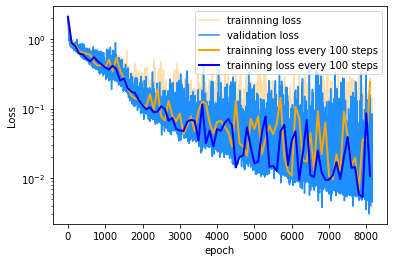

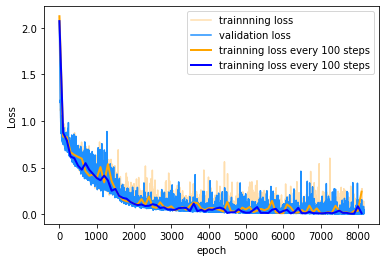

In [18]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 



x_avg_train_loss = []
y_avg_train_loss = []
x_avg_val_loss = []
y_avg_val_loss = []

x_val_precision = []
y_val_precision = []

x_avg_val_recall = []
y_avg_val_recall = []

x_avg_val_f1 = []
y_avg_val_f1 = []

for i in range(0,len(train_loss)):
   if i%100==0:
      x_avg_train_loss.append(i)
      y_avg_train_loss.append(train_loss[i]) 

for i in range(0,len(val_loss)):
   if i%100==0:
      x_avg_val_loss.append(i)
      y_avg_val_loss.append(val_loss[i]) 
      

for i in range(0,len(val_loss)):
  if i%100==0:
    try:
      x_val_precision.append(i)
      y_val_precision.append(val_precision[i])
      x_avg_val_recall.append(i)
      y_avg_val_recall.append(val_recall[i])
      x_avg_val_f1.append(i)
      y_avg_val_f1.append(val_f1[i])
    except:
      break
        

# # Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')



plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig(path_btt_large_qv+'/btt_qv_lr__star_1e5_log_test.png')
plt.legend()
plt.show()
# Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path_btt_large_qv+'/btt_qv_star_lr_1e5_test.png')
plt.show()



## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [19]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)
import numpy as np

from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
print(device)
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np
# PATH=path_btt_large_qv +'/model/large_model_xlm_btt_qv_lr_star_1e5.pt'
# model = torch.load(PATH)

preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
batch_test_array = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
      
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )
        


cuda:0


Evaluating:   0%|          | 0/510 [00:00<?, ?it/s]

In [20]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [21]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.9341367713004485, 'recall': 0.9480870430948656, 'f1': 0.9410602103479918}
              precision    recall  f1-score   support

      ASE_ID       0.97      0.95      0.96      1701
       AX_ID       0.89      0.95      0.92       817
OT_AMOUNT_ID       0.92      0.90      0.91       842
         ase       0.96      0.95      0.95       954
          ax       0.92      0.98      0.95       886
    otAmount       0.92      0.95      0.94       893
      ueDate       0.93      0.96      0.94       938

   micro avg       0.93      0.95      0.94      7031
   macro avg       0.93      0.95      0.94      7031
weighted avg       0.93      0.95      0.94      7031



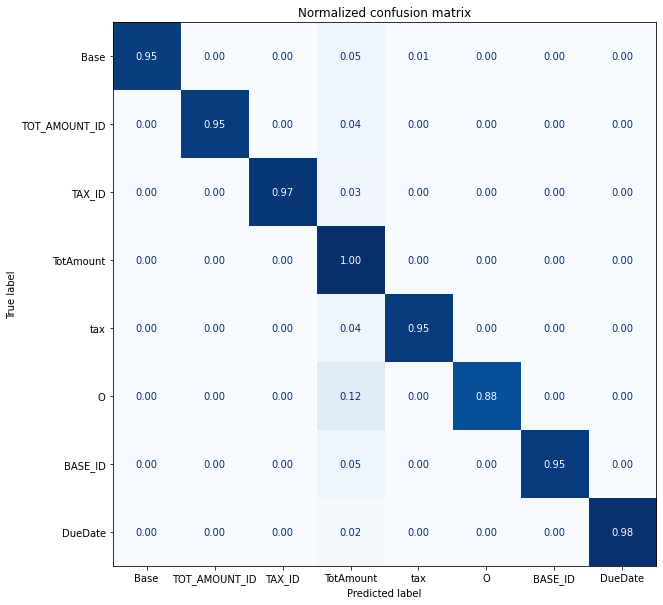

In [22]:
from matplotlib import figure
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import itertools

def plot_confusion_matrix(y_preds,y_true,labels):
  cm = confusion_matrix(y_true,y_preds,normalize= "true")
  fig, ax = plt.subplots(figsize=(10,10))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
  disp.plot(cmap="Blues",values_format=".2f",ax=ax,colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

def results_cm(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])


  return out_label_list,preds_list
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

# plot_confusion_matrix(preds_val, out_label_ids, labels)
# preds_val
out_label_list,preds_list =results_cm(preds_val, out_label_ids, labels)

out_label_list = list(itertools.chain(*out_label_list))
preds_list = list(itertools.chain(*preds_list))


plot_confusion_matrix(preds_list,out_label_list, labels)